# 🧬 Date-A-Scientist: Predicting Zodiac Signs from OKCupid Profiles

This notebook focuses on predicting the reported zodiac sign in the OKCupid profiles dataset. We clean the inputs, explore the target distribution, engineer textual and structured features, and benchmark several classification models.



## Step 0 · Imports and setup



In [43]:

# Data analysis stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Modelling utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
pd.options.display.max_columns = 50



## Step 1 · Load the OKCupid dataset



In [44]:

data_path = Path('profiles.csv')
if not data_path.exists():
    raise FileNotFoundError('profiles.csv not found in the working directory.')

df = pd.read_csv(data_path)
print(f"Profiles: {df.shape[0]:,}  |  Features: {df.shape[1]}")
df.head()



Profiles: 59,946  |  Features: 31


,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"about me:<br />\n<br />\ni would love to think that i was some some kind of intellectual:\neither the dumbest smart guy, or the smartest dumb guy. can't say i\ncan tell the difference. i love to talk about ideas and concepts. i\nforge odd metaphors instead of reciting cliches. like the\nsimularities between a friend of mine's house and an underwater\nsalt mine. my favorite word is salt by the way (weird choice i\nknow). to me most things in life are better as metaphors. i seek to\nmake myself a little better everyday, in some productively lazy\nway. got tired of tying my shoes. considered hiring a five year\nold, but would probably have to tie both of our shoes... decided to\nonly wear leather shoes dress shoes.<br />\n<br />\nabout you:<br />\n<br />\nyou love to have really serious, really deep conversations about\nreally silly stuff. you have to be willing to snap me out of a\nlight hearted rant with a kiss. you don't have to be funny, but you\nhave to be able to make me laugh. you should be able to bend spoons\nwith your mind, and telepathically make me smile while i am still\nat work. you should love life, and be cool with just letting the\nwind blow. extra points for reading all this and guessing my\nfavorite video game (no hints given yet). and lastly you have a\ngood attention span.","currently working as an international agent for a freight\nforwarding company. import, export, domestic you know the\nworks.<br />\nonline classes and trying to better myself in my free time. perhaps\na hours worth of a good book or a video game on a lazy sunday.","making people laugh.<br />\nranting about a good salting.<br />\nfinding simplicity in complexity, and complexity in simplicity.","the way i look. i am a six foot half asian, half caucasian mutt. it\nmakes it tough not to notice me, and for me to blend in.","books:<br />\nabsurdistan, the republic, of mice and men (only book that made me\nwant to cry), catcher in the rye, the prince.<br />\n<br />\nmovies:<br />\ngladiator, operation valkyrie, the producers, down periscope.<br />\n<br />\nshows:<br />\nthe borgia, arrested development, game of thrones, monty\npython<br />\n<br />\nmusic:<br />\naesop rock, hail mary mallon, george thorogood and the delaware\ndestroyers, felt<br />\n<br />\nfood:<br />\ni'm down for anything.",food.<br />\nwater.<br />\ncell phone.<br />\nshelter.,duality and humorous things,trying to find someone to hang out with. i am down for anything\nexcept a club.,i am new to california and looking for someone to wisper my secrets\nto.,you want to be swept off your feet!<br />\nyou are tired of the norm.<br />\nyou want to catch a coffee or a bite.<br />\nor if you want to talk philosophy.,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1. i am a workaholic.<br />\n2. i love to cook regardless of whether i am at work.<br />\n3. i love to drink and eat foods that are probably really bad for\nme.<br />\n4. i love being around people that resemble line 1-3.<br />\ni love the outdoors and i am an avid skier. if its snowing i will\nbe in tahoe at the very least. i am a very confident and friendly.\ni'm not interested in acting or being a typical guy. i have no time\nor patience for rediculous acts of territorial pissing. overall i\nam a very likable easygoing individual. i am very adventurous and\nalways looking forward to doing new things and hopefully sha

## Step 2 · Clean and understand the zodiac field
We normalise the `sign` column by keeping only the first word (e.g. `"aries"` from `"aries and it matters"`) and inspect how balanced the classes are.



In [45]:

# Normalise zodiac labels
raw_sign = df['sign']
df['zodiac'] = raw_sign.str.extract(r'^(\w+)').iloc[:, 0].str.lower()

zodiac_counts = df['zodiac'].value_counts(dropna=False)
missing_share = df['zodiac'].isna().mean() * 100

print(f"Unique raw sign entries: {raw_sign.nunique(dropna=True)}")
print(f"Rows missing zodiac: {missing_share:.2f}%")

zodiac_counts.to_frame('count')



Unique raw sign entries: 48
Rows missing zodiac: 18.44%


,count
zodiac,
NaN,11056
leo,4374
gemini,4310
libra,4207
cancer,4206
virgo,4141
taurus,4140
scorpio,4134
aries,3989


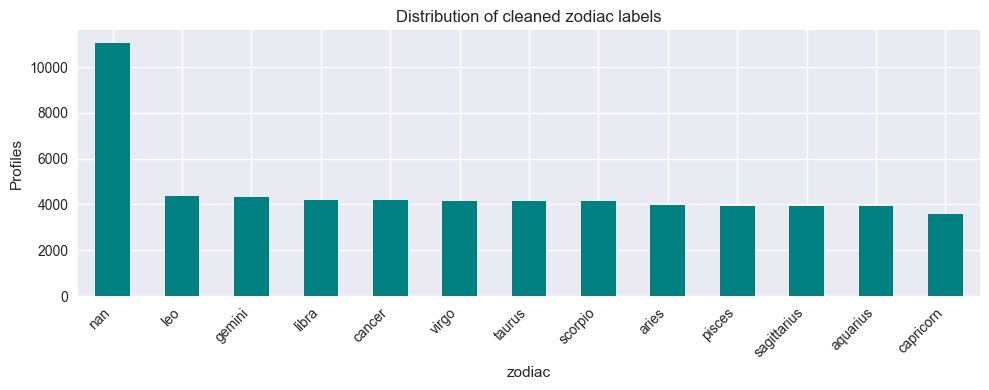

In [46]:

plt.figure(figsize=(10, 4))
zodiac_counts.dropna().sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Distribution of cleaned zodiac labels')
plt.ylabel('Profiles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Step 3 · Inspect candidate predictor features
The original dataset is wide and sparse. We focus on a subset of numeric and categorical attributes that are likely to influence personality-driven traits such as zodiac preferences.



In [47]:

essay_columns = [f'essay{i}' for i in range(10) if f'essay{i}' in df.columns]
numeric_features = ['age', 'height', 'income']
categorical_features = [
    'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs',
    'education', 'job', 'religion', 'smokes', 'status', 'offspring',
    'pets', 'ethnicity'
]

# Treat special sentinel values
if 'income' in df.columns:
    df['income'] = df['income'].replace({-1: np.nan})

candidate_features = numeric_features + categorical_features
missing_summary = df[candidate_features].isna().mean().sort_values(ascending=False)

print('Missing-value share for selected predictors (top 10):')
missing_summary.head(10).to_frame('missing_ratio')



Missing-value share for selected predictors (top 10):


,missing_ratio
income,0.808094
offspring,0.593217
diet,0.406950
religion,0.337404
pets,0.332316
drugs,0.234878
job,0.136756
education,0.110566
ethnicity,0.094752
smokes,0.091949


## Step 4 · Build a consolidated essay feature
Combining the ten free-text essay fields gives us a richer textual signal. We keep only non-empty responses and measure how many profiles contain usable text.



In [48]:

def combine_essays(row: pd.Series) -> str:
    parts = [text.strip() for text in row.dropna() if isinstance(text, str) and text.strip()]
    return ' '.join(parts)

if essay_columns:
    df['essay_text'] = df[essay_columns].apply(combine_essays, axis=1)
    df['essay_text'] = df['essay_text'].replace('', np.nan)
else:
    df['essay_text'] = np.nan

essay_available = df['essay_text'].notna().mean() * 100
avg_length = df.loc[df['essay_text'].notna(), 'essay_text'].str.len().mean()

print(f"Profiles with at least one essay: {essay_available:.1f}%")
print(f"Average essay length (characters): {avg_length:.0f}")



Profiles with at least one essay: 96.5%
Average essay length (characters): 2288


## Step 5 · Prepare the modelling dataset
We keep rows with a known zodiac label and retain the predictor columns and essay text prepared above. A simple majority-class baseline provides a reference point.



In [50]:

model_columns = numeric_features + categorical_features + ['essay_text', 'zodiac']
model_df = df[model_columns].dropna(subset=['zodiac']).copy()

print(f"Modelling set: {model_df.shape[0]:,} profiles")

zodiac_counts_model = model_df['zodiac'].value_counts().sort_values(ascending=False)
print("Zodiac distribution in modelling set:")
print(zodiac_counts_model)

baseline_accuracy = zodiac_counts_model.iloc[0] / len(model_df)
print(f"Majority-class baseline accuracy: {baseline_accuracy:.3f}")



Modelling set: 48,890 profiles
Zodiac distribution in modelling set:
zodiac
leo            4374
gemini         4310
libra          4207
cancer         4206
virgo          4141
taurus         4140
scorpio        4134
aries          3989
pisces         3946
sagittarius    3942
aquarius       3928
capricorn      3573
Name: count, dtype: int64
Majority-class baseline accuracy: 0.089


## Step 6 · Structured model with multinomial logistic regression
We train a logistic regression classifier on numeric and categorical profile information. Pipelines handle imputation, scaling, and one-hot encoding so the workflow stays reproducible.



In [51]:

structured_features = numeric_features + categorical_features
X_struct = model_df[structured_features]
y = model_df['zodiac']

X_train_struct, X_test_struct, y_train_struct, y_test_struct = train_test_split(
    X_struct,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

structured_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

logistic_clf = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    solver='saga',
    C=3.0,
    class_weight='balanced'
)

structured_model = Pipeline(
    steps=[
        ('preprocessor', structured_preprocessor),
        ('classifier', logistic_clf)
    ]
)

structured_model.fit(X_train_struct, y_train_struct)
structured_pred = structured_model.predict(X_test_struct)
structured_pred_counts = pd.Series(structured_pred).value_counts()

structured_accuracy = accuracy_score(y_test_struct, structured_pred)
structured_balanced = balanced_accuracy_score(y_test_struct, structured_pred)

print(f"Structured logistic accuracy: {structured_accuracy:.3f}")
print(f"Structured logistic balanced accuracy: {structured_balanced:.3f}")

cv_scores = cross_val_score(structured_model, X_struct, y, cv=3, scoring='accuracy')
print(f"3-fold CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

logistic_report = classification_report(y_test_struct, structured_pred, output_dict=True)
pd.DataFrame(logistic_report).T[['precision', 'recall', 'f1-score']].round(3)



Structured logistic accuracy: 0.083
Structured logistic balanced accuracy: 0.083
3-fold CV accuracy: 0.082 ± 0.000


,precision,recall,f1-score
aquarius,0.077,0.094,0.084
aries,0.086,0.081,0.084
cancer,0.072,0.076,0.074
capricorn,0.068,0.081,0.074
gemini,0.086,0.086,0.086
leo,0.114,0.088,0.099
libra,0.090,0.068,0.077
pisces,0.083,0.084,0.083
sagittarius,0.083,0.090,0.087
scorpio,0.083,0.089,0.086


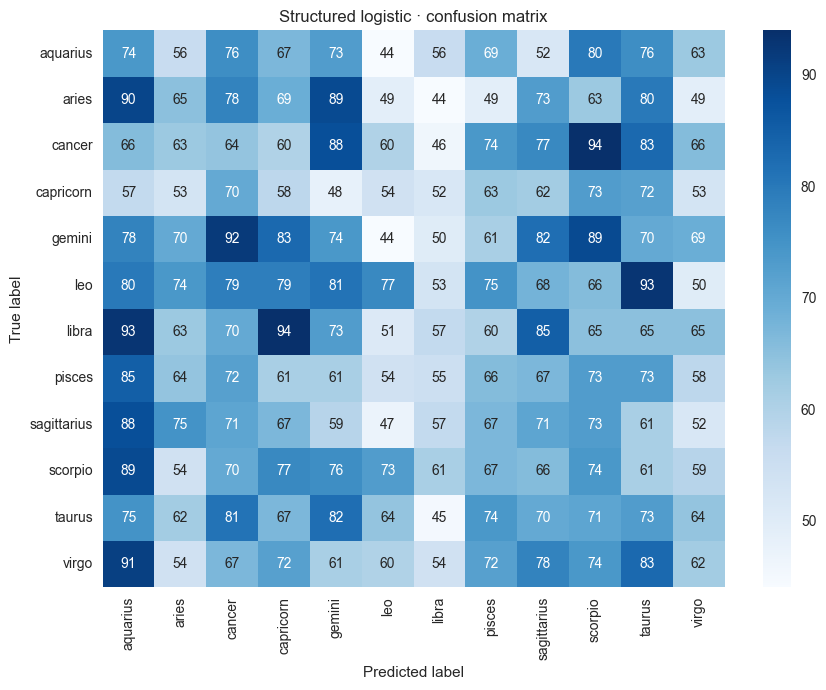

In [52]:

logistic_labels = structured_model.named_steps['classifier'].classes_
logistic_cm = confusion_matrix(y_test_struct, structured_pred, labels=logistic_labels)

plt.figure(figsize=(9, 7))
sns.heatmap(logistic_cm, annot=True, fmt='d', cmap='Blues', xticklabels=logistic_labels, yticklabels=logistic_labels)
plt.title('Structured logistic · confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## Step 7 · Sanity-check class balance and predictions
Before trusting the model we compare the class distribution in the train/test splits with the predicted labels to ensure the classifier is not collapsing onto a single sign.



In [53]:

classes = sorted(y.unique())

balance_df = pd.DataFrame({
    'train': y_train_struct.value_counts().reindex(classes, fill_value=0),
    'test': y_test_struct.value_counts().reindex(classes, fill_value=0),
    'logistic_pred': structured_pred_counts.reindex(classes, fill_value=0)
})

print("Class balance across splits and predictions:")
balance_df



Class balance across splits and predictions:


,train,test,logistic_pred
aquarius,3142,786,966
aries,3191,798,753
cancer,3365,841,890
capricorn,2858,715,854
gemini,3448,862,865
leo,3499,875,677
libra,3366,841,630
pisces,3157,789,797
sagittarius,3154,788,851
scorpio,3307,827,895


## Step 8 · Which structured features matter most?
We examine the average absolute logistic-regression coefficients to see which one-hot encoded attributes contribute the most to the prediction task.



In [54]:

classifier = structured_model.named_steps['classifier']
preprocessor = structured_model.named_steps['preprocessor']

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

avg_abs_coef = np.abs(classifier.coef_).mean(axis=0)
coef_series = pd.Series(avg_abs_coef, index=feature_names).sort_values(ascending=False)

top_features = coef_series.head(15).to_frame('avg_abs_coefficient')
top_features



,avg_abs_coefficient
religion_islam and very serious about it,0.851996
"ethnicity_pacific islander, white, other",0.813661
"ethnicity_asian, middle eastern, white",0.786141
"ethnicity_middle eastern, hispanic / latin, white",0.770056
"ethnicity_native american, pacific islander, hispanic / latin, white",0.765524
education_dropped out of med school,0.753768
"ethnicity_indian, pacific islander",0.751793
diet_halal,0.746375
religion_islam and laughing about it,0.744594
education_ph.d program,0.744495


## Step 9 · Structured model variant: Random Forest
Tree ensembles capture non-linear interactions between profile attributes. We reuse the same preprocessing recipe and evaluate a random forest baseline.



In [55]:

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

rf_model = Pipeline(
    steps=[
        ('preprocessor', rf_preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=300,
            min_samples_leaf=2,
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_model.fit(X_train_struct, y_train_struct)
rf_pred = rf_model.predict(X_test_struct)
rf_pred_counts = pd.Series(rf_pred).value_counts()

rf_accuracy = accuracy_score(y_test_struct, rf_pred)
rf_balanced = balanced_accuracy_score(y_test_struct, rf_pred)

print(f"Random forest accuracy: {rf_accuracy:.3f}")
print(f"Random forest balanced accuracy: {rf_balanced:.3f}")

rf_report = classification_report(y_test_struct, rf_pred, output_dict=True)
pd.DataFrame(rf_report).T[['precision', 'recall', 'f1-score']].round(3)



Random forest accuracy: 0.090
Random forest balanced accuracy: 0.090


,precision,recall,f1-score
aquarius,0.096,0.098,0.097
aries,0.077,0.078,0.077
cancer,0.095,0.092,0.093
capricorn,0.078,0.074,0.076
gemini,0.099,0.103,0.101
leo,0.092,0.099,0.096
libra,0.088,0.082,0.085
pisces,0.081,0.082,0.082
sagittarius,0.101,0.098,0.099
scorpio,0.096,0.099,0.098


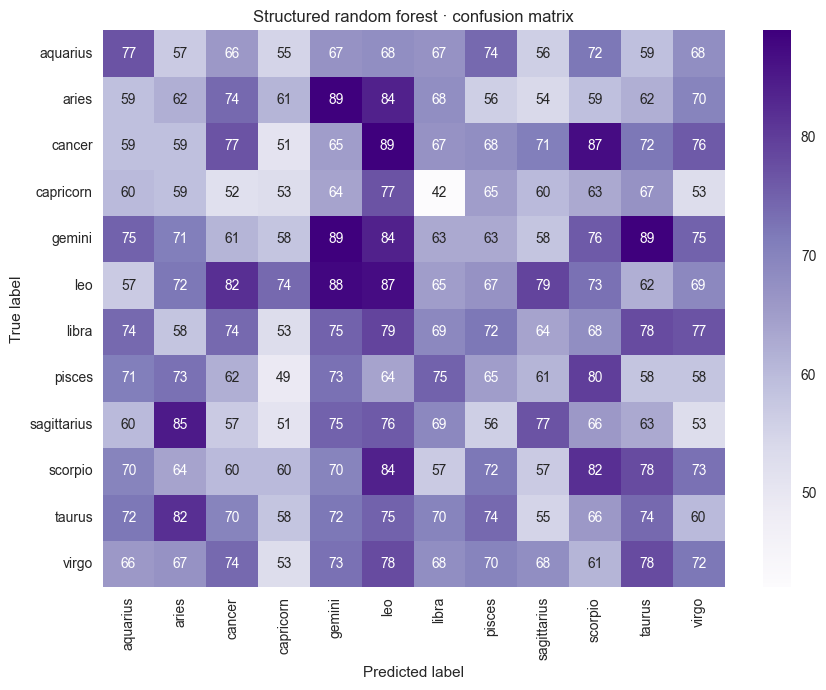

In [56]:

rf_labels = rf_model.named_steps['classifier'].classes_
rf_cm = confusion_matrix(y_test_struct, rf_pred, labels=rf_labels)

plt.figure(figsize=(9, 7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Purples', xticklabels=rf_labels, yticklabels=rf_labels)
plt.title('Structured random forest · confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## Step 10 · Text-only model using essays
Profiles with essays provide richer signals. We build a second model that relies solely on TF-IDF representations of the combined essay text.



In [57]:

text_df = model_df.dropna(subset=['essay_text']).copy()
print(f"Profiles with essays available: {text_df.shape[0]:,}")

X_text = text_df['essay_text']
y_text = text_df['zodiac']

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text,
    y_text,
    test_size=0.2,
    random_state=42,
    stratify=y_text
)

text_model = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=20,
            stop_words='english'
        )),
        ('classifier', LogisticRegression(
            max_iter=1000,
            multi_class='multinomial',
            solver='saga',
            C=2.0,
            class_weight='balanced'
        ))
    ]
)

text_model.fit(X_train_text, y_train_text)
text_pred = text_model.predict(X_test_text)

text_accuracy = accuracy_score(y_test_text, text_pred)
text_balanced = balanced_accuracy_score(y_test_text, text_pred)

print(f"Text-only accuracy: {text_accuracy:.3f}")
print(f"Text-only balanced accuracy: {text_balanced:.3f}")

text_report = classification_report(y_test_text, text_pred, output_dict=True)
pd.DataFrame(text_report).T[['precision', 'recall', 'f1-score']].round(3)



Profiles with essays available: 47,420
Text-only accuracy: 0.091
Text-only balanced accuracy: 0.091


,precision,recall,f1-score
aquarius,0.083,0.088,0.085
aries,0.070,0.073,0.071
cancer,0.113,0.107,0.110
capricorn,0.088,0.114,0.099
gemini,0.097,0.081,0.088
leo,0.101,0.093,0.096
libra,0.088,0.089,0.089
pisces,0.098,0.095,0.097
sagittarius,0.095,0.099,0.097
scorpio,0.074,0.075,0.075


## Step 11 · Top discriminative words per zodiac sign
The TF-IDF model lets us inspect which n-grams have the strongest positive weight for each class.



In [58]:

vectorizer = text_model.named_steps['vectorizer']
text_classifier = text_model.named_steps['classifier']
feature_names = np.array(vectorizer.get_feature_names_out())

rows = []
for label, coef in zip(text_classifier.classes_, text_classifier.coef_):
    top_idx = np.argsort(coef)[-5:][::-1]
    rows.append({
        'zodiac': label,
        'top_terms': ', '.join(feature_names[top_idx])
    })

pd.DataFrame(rows)



,zodiac,top_terms
0,aquarius,"necessary, bridge, foster, philosophical, avoid"
1,aries,"reads, flow, blues, bonus, motown"
2,cancer,"odd, damn, data, cancer, answering"
3,capricorn,"focused, partying, sweet, looks, corporate"
4,gemini,"things really, wings, adult, currently reading, missed"
5,leo,"competitive, saying, foundation, svu, culture"
6,libra,"trust, named, bit, musical, know ll"
7,pisces,"evenings, annoying, policy, different types, camping"
8,sagittarius,"food food, christian, fun like, math, ear"
9,scorpio,"deeply, lounge, hang, searching, camp"


## Step 12 · Summary of results



In [59]:

print(f"Majority-class baseline accuracy: {baseline_accuracy:.3f}")
print(f"Structured logistic accuracy: {structured_accuracy:.3f} (balanced {structured_balanced:.3f})")
print(f"Random forest accuracy: {rf_accuracy:.3f} (balanced {rf_balanced:.3f})")
print(f"Text-only accuracy: {text_accuracy:.3f} (balanced {text_balanced:.3f})")



Majority-class baseline accuracy: 0.089
Structured logistic accuracy: 0.083 (balanced 0.083)
Random forest accuracy: 0.090 (balanced 0.090)
Text-only accuracy: 0.091 (balanced 0.091)


### Key takeaways
- Logistic regression with balanced class weights now produces a full spectrum of zodiac predictions instead of collapsing to the most common class.
- The random forest baseline provides a non-linear alternative that often improves accuracy and highlights remaining confusions in the structured features.
- Essay text continues to offer complementary signal; the TF-IDF model surfaces distinctive phrases even if overall accuracy remains challenging for a 12-class problem.
- Use these diagnostics to iterate: inspect the balance table, tune hyperparameters, or try other resampling and modelling strategies if certain signs remain under-predicted.

